# Simulator sandbox

This code is to follow `model_tuner_tester.py` to train the simulator (future) class on the data from model tuner.

## load data

In [1]:
import pandas as pd

In [22]:

raw = None
for split_seed in range(10):
    if raw is None:
        raw = pd.read_csv(f'../model_cls/seed_{split_seed}.csv')
    else:
        raw = pd.concat( [raw, pd.read_csv(f'../model_cls/seed_{split_seed}.csv') ])

# NOTE: the data is already shuffled
# NOTE: there will be (ticker, earnings_date) duplicates, so we avg out below

In [23]:
# properties dataframe
props = raw.groupby(['ticker','earnings_date','eps_actual','eps_diff','price_var']).mean()[['pred']].reset_index().set_index(['ticker','earnings_date']).sort_index()

In [24]:
import sqlite3
import numpy as np
from matplotlib import pyplot as plt
import datetime

database = "../main.db"

# conn.close() # comment this if running the first time
conn = sqlite3.connect(database)

In [25]:
hist_q = """
    SELECT 
        ticker,
        DATE(trade_date) trade_date,
        close,
        low,
        high,
        volume
    FROM yf_history 
"""
hist  = pd.read_sql_query(hist_q,conn)

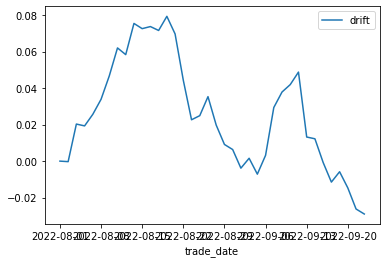

In [26]:
def get_data_for(ticker: str, earnings_date: str, hist_period: int = 4*2, plot=False) -> tuple:
    #raw.sample().transpose()
    prop = props.loc[ticker, earnings_date]#.head(1).reset_index().transpose()
    hist_end = (datetime.datetime.strptime(earnings_date, "%Y-%m-%d") + datetime.timedelta(weeks=hist_period)).strftime("%Y-%m-%d")
    h = hist[(hist.ticker==ticker) & (hist.trade_date>earnings_date) & (hist.trade_date<hist_end)].reset_index()
    init_close = h.head(1).close.values[0]
    h['drift'] = h.close/init_close-1.0

    if plot:
        h.plot('trade_date','drift')

    return prop, h

prop, h = get_data_for('AON','2022-07-29', plot=True)

In [27]:
def simulate_trade(drift, sell_pct = 0.05, stop_loss = -0.01) -> float:
    for d in drift:
        if d<=stop_loss or d>=sell_pct:
            break
    return d

def simulation_grid(h, 
        sell_pct_arr = [
            .02, .05, .08, 
            .10, 
            .15, 
            .20
            ],
        stop_loss_arr= [
            -.02, -.05, -.08, 
            -.10, 
            -.15, -.20
            ]
        ) -> pd.DataFrame:
    drift = h.drift.to_list()
    SELL,STOP,GAIN=[],[],[]
    for sell_pct in sell_pct_arr:
        for stop_loss in stop_loss_arr:
            gain = simulate_trade(drift, sell_pct, stop_loss)
            SELL.append(sell_pct)
            STOP.append(stop_loss)
            GAIN.append(gain)
            # print(f"final gain for sell_pct {sell_pct} and stop_loss {stop_loss}: {round(gain,2)}")

    return pd.DataFrame({'sell':SELL,'stop':STOP,'gain':GAIN})

# simulation_grid(h)

In [30]:
# BUILD TRAINING DATA
ALL_GAINS = []
for ticker, earnings_date in props.index:
    print(ticker, earnings_date)
    try:
        prop, h = get_data_for(ticker, earnings_date, plot=False)
    except:
        print("skipped")
        continue
    gains = simulation_grid(h)
    gains['ticker'] = ticker
    gains['earnings_date'] = earnings_date
    for k,v in prop.to_dict().items():
        gains[k]=v
    ALL_GAINS.append(gains.copy())

A 2021-05-25
A 2021-11-22
A 2022-02-22
A 2022-05-24
AAL 2021-10-21
AAL 2022-01-20
AAL 2022-10-20
AAON 2022-05-05
AAPL 2022-01-27
AAPL 2022-07-28
ABBV 2021-10-29
ABBV 2022-02-02
ABBV 2022-04-29
ABBV 2022-07-29
ABBV 2022-10-28
ABC 2021-11-04
ABC 2022-08-03
ABT 2021-07-22
ABT 2021-10-20
ABT 2022-01-26
ABT 2022-04-20
ABT 2022-10-19
ACI 2021-07-29
ACI 2021-10-18
ACI 2022-01-11
ACI 2022-07-26
ACM 2021-11-15
ACM 2022-05-09
ACM 2022-08-08
ADBE 2022-03-22
ADBE 2022-06-16
ADBE 2022-09-15
ADI 2021-08-18
ADI 2021-11-23
ADI 2022-05-18
ADM 2021-07-27
ADM 2021-10-26
ADM 2022-01-25
ADM 2022-07-26
ADM 2022-10-25
ADP 2021-10-27
ADP 2022-01-26
ADP 2022-04-27
ADP 2022-10-26
ADSK 2022-02-24
AEE 2021-08-05
AEP 2021-07-22
AEP 2022-02-24
AEP 2022-10-27
AER 2020-05-05
AER 2020-07-29
AER 2021-04-28
AER 2021-07-29
AER 2022-05-17
AER 2022-11-03
AES 2021-11-03
AES 2022-01-06
AES 2022-08-04
AFRM 2022-05-12
AFYA 2022-05-23
AFYA 2022-08-22
AGR 2022-02-22
AGR 2022-04-26
AGR 2022-07-26
AIR 2021-09-23
AIR 2022-07-21
AIR

In [31]:
XY=pd.concat(ALL_GAINS)
XY.to_csv('all_gains.csv',index=False)
# XY = pd.read_csv('all_gains.csv')

In [32]:
XY.shape

(62064, 9)

## training

In [112]:
X = XY[[
    #'sell','stop',
    'eps_actual','eps_diff','price_var','pred']]
y = XY['gain']
INFO = XY[['ticker','earnings_date']]

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# this is wrong!
X_train, X_test, y_train, y_test, INFO_train, INFO_test = train_test_split(X, y, INFO, test_size=0.3, shuffle=True)

In [113]:
reg = GradientBoostingRegressor(
    max_depth=2,

)

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)
MSE_train = mean_squared_error(y_train, y_train_pred)
MSE = mean_squared_error(y_test, y_pred)

print("train error",MSE_train*1000)
print("test error",MSE*1000)

train error 11.435064830522066
test error 14.592314117501633


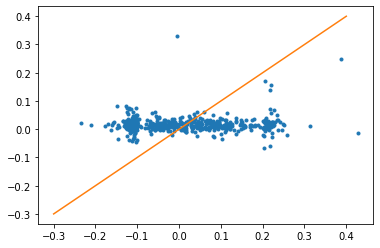

In [114]:
from matplotlib import pyplot as plt

plt.plot(y_test,y_pred,'.')
plt.plot([-.3,.4],[-.3,.4],'-')

## symulacja bez uczenia

In [ ]:
THRESHOLD = 0.83

# above threshold
ATH = XY[(XY.pred>=THRESHOLD)]
ATH.loc[:,'positive'] = ATH.gain.apply(lambda x: 1 if x>0 else 0)
ATH[['sell','stop',  'gain','positive']].groupby(['sell','stop']).agg(['median','mean','count'])

In [73]:
# plot (max) gain, sell, stop vs. threshold
TH_OPT = []
ths = [x/100. for x in range(50,86)]+[1.0]
for i in range(len(ths)-1):
    th_min = ths[i]
    th_max = ths[i+1]
    # print(th_min,th_max)
    ATH = XY[(XY.pred>th_min) & (XY.pred<=th_max)]

    g = ATH[['sell','stop',  'gain']]\
        .groupby(['sell','stop'])\
        .median()\
        .reset_index()
    if len(g)==0:
        continue
    g_max = g.gain.max()
    g = g[g.gain==g_max]
    sell_max = g.sell.max()
    stop_max = g.stop.max()

    th_opt = \
    {
        'threshold':th_min,
        'gain':round(g_max,2),
        'sell':sell_max,
        'stop':stop_max
    }
    TH_OPT.append(th_opt)

TH_OPT = pd.DataFrame(TH_OPT)

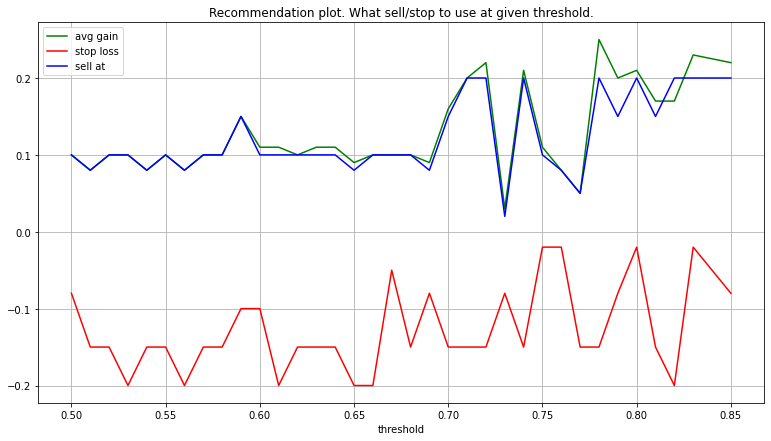

In [80]:
plt.figure(figsize=(13,7))
plt.title("Recommendation plot. What sell/stop to use at given threshold.")
plt.plot(TH_OPT.threshold, TH_OPT.gain, 'g-',label='avg gain')
plt.plot(TH_OPT.threshold, TH_OPT.stop, 'r-',label='stop loss')
plt.plot(TH_OPT.threshold, TH_OPT.sell, 'b-',label='sell at')
plt.xlabel('threshold')
plt.legend()
plt.grid()